In [2]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"


print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13333556 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7040910292272066862
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10977804460004010289
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1780967433157814963
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6957153271921489055
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
import xgboost 
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
master=pd.read_csv('/content/predictive_maintenance.csv')
master.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [7]:
master.isnull().sum()/len(master)*100

date       0.0
device     0.0
failure    0.0
metric1    0.0
metric2    0.0
metric3    0.0
metric4    0.0
metric5    0.0
metric6    0.0
metric7    0.0
metric8    0.0
metric9    0.0
dtype: float64

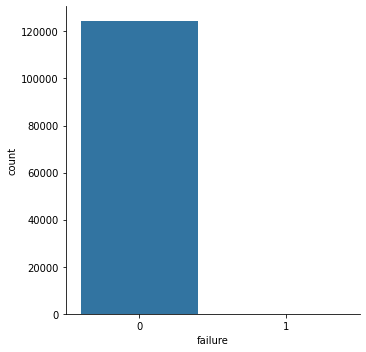

In [6]:
#TOTALLY IMBALANCE#
sns.catplot(x='failure',kind='count',data=master)

In [13]:
#DROP DATE#
master=master.drop(['date'],axis=1)

In [14]:
master.head()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


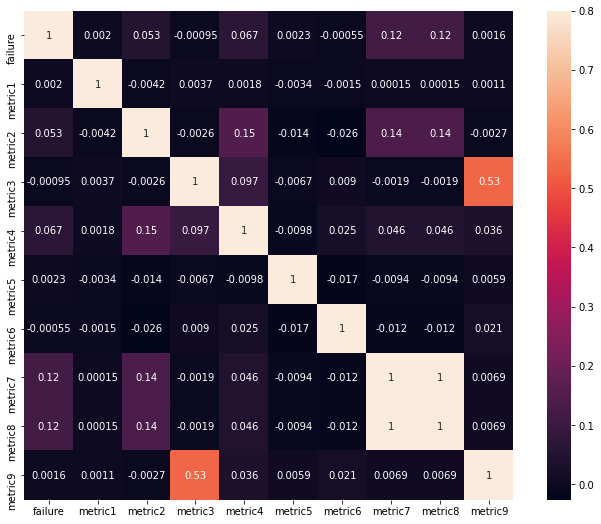

In [10]:
#CORRELATION MATRIX#
contvars=master.corr()
fig,ax=plt.subplots(figsize=(12,9))
sns.heatmap(contvars,vmax=.8,annot = True,square=True);

In [16]:
#MODEL BUILDING#
X = master.drop(['failure','device'],axis = 1)
Y = master['failure']

###########SMOTE############
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

####SCALING#######
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

##SPLITIING#
X_trains, X_vals, y_trains, y_vals = train_test_split(X,Y, test_size = 0.2, random_state =1)


In [18]:
pip install catboost

     |████████████████████████████████| 64.8MB 46kB/s 


In [21]:
import sklearn.ensemble as ensemble
from catboost import CatBoostClassifier

lr = LogisticRegression()
rf=RandomForestClassifier()
adb=ensemble.AdaBoostClassifier()
bgc=ensemble.BaggingClassifier()
gnb = GaussianNB()
knn=KNeighborsClassifier()
dt = DecisionTreeClassifier()
bgcl_lr = BaggingClassifier(base_estimator=lr, random_state=0)
xgb=xgboost.XGBClassifier()
cat=CatBoostClassifier()

# ,ab_rf,ab_dt,ab_nb,ab_lr,bgcl_lr

models=[lr,rf,adb,bgc,gnb,knn,dt,bgcl_lr,xgb,cat]
sctr,scte,auc,ps,rs=[],[],[],[],[]
def ens(X_trains,X_vals, y_trains, y_vals):
    for model in models:
            model.fit(X_trains, y_trains)
            y_test_pred = model.predict(X_vals)
            y_test_pred_new=model.predict_proba(X_vals)
            y_test_pred_new=y_test_pred_new[:,1]
            train_score=model.score(X_trains,y_trains)
            test_score=model.score(X_vals,y_vals)
            p_score=metrics.precision_score(y_vals,y_test_pred)
            r_score=metrics.recall_score(y_vals,y_test_pred)
            
            ac=metrics.roc_auc_score(y_vals,y_test_pred_new)
            
            sctr.append(train_score)
            scte.append(test_score)
            ps.append(p_score)
            rs.append(r_score)
            auc.append(ac)
    return sctr,scte,auc,ps,rs
ens(X_trains,X_vals, y_trains, y_vals)
# 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'
ensemble=pd.DataFrame({'names':['Logistic Regression','Random Forest','Ada boost','Bagging',
                                'Naive-Bayes','KNN','Decistion Tree',
                                'bagged LR','XgBoost','CatBoost'],
                       'auc_score':auc,'training':sctr,'testing':scte,'precision':ps,'recall':rs})
ensemble=ensemble.sort_values(by='auc_score',ascending=False).reset_index(drop=True)
ensemble

Learning rate set to 0.098756
0:	learn: 0.5497824	total: 140ms	remaining: 2m 20s
1:	learn: 0.4502922	total: 223ms	remaining: 1m 51s
2:	learn: 0.3750004	total: 300ms	remaining: 1m 39s
3:	learn: 0.3204653	total: 377ms	remaining: 1m 33s
4:	learn: 0.2868739	total: 457ms	remaining: 1m 31s
5:	learn: 0.2600234	total: 534ms	remaining: 1m 28s
6:	learn: 0.2397987	total: 612ms	remaining: 1m 26s
7:	learn: 0.2266081	total: 690ms	remaining: 1m 25s
8:	learn: 0.2155534	total: 768ms	remaining: 1m 24s
9:	learn: 0.2030487	total: 845ms	remaining: 1m 23s
10:	learn: 0.1955576	total: 925ms	remaining: 1m 23s
11:	learn: 0.1874226	total: 1s	remaining: 1m 22s
12:	learn: 0.1812891	total: 1.09s	remaining: 1m 22s
13:	learn: 0.1772200	total: 1.18s	remaining: 1m 23s
14:	learn: 0.1722053	total: 1.26s	remaining: 1m 22s
15:	learn: 0.1685880	total: 1.33s	remaining: 1m 22s
16:	learn: 0.1653199	total: 1.41s	remaining: 1m 21s
17:	learn: 0.1614573	total: 1.49s	remaining: 1m 21s
18:	learn: 0.1575278	total: 1.57s	remaining: 1m

,names,auc_score,training,testing,precision,recall
0,Random Forest,0.999950,1.000000,0.998754,0.998182,0.999312
1,CatBoost,0.999835,0.997548,0.996483,0.994480,0.998463
2,Bagging,0.999642,0.999884,0.998131,0.997415,0.998827
3,KNN,0.997995,0.994307,0.991820,0.984807,0.998948
4,Decistion Tree,0.997153,1.000000,0.997146,0.996045,0.998220
5,XgBoost,0.992082,0.951929,0.951905,0.954673,0.948224
6,Ada boost,0.984690,0.939338,0.940510,0.954929,0.923873
7,bagged LR,0.929503,0.829670,0.834010,0.957483,0.696869
8,Logistic Regression,0.928855,0.830625,0.834874,0.957839,0.698406
9,Naive-Bayes,0.838429,0.701507,0.704156,0.975833,0.414853
